## Lungs detection

Binary Object Detection / Regression notebook 

NOTE: I run this notebook with fast.ai v2.5 & Python 3.7.6. 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 0 = id of the gpu
# To know which id have to be set on the previous line, on Windows 10 run "nvidia-smi" on CMD to check all the installed GPUs data, like
# the id, driver version and CUDA version 

# Check if your GPU driver and CUDA is enabled and is accessible by PyTorch
# TO USE CUDA SELECT A GPU ON THE EXECUTION ENVIRONMENT, NOT A TPU
import torch; print(torch.version.cuda) # the CUDA version must be printed
print(torch.cuda.is_available()) # True must be printed (if False press on the Restart button at the top of the notebook)
print(torch.cuda.current_device()) # the id of the GPU must be printed

11.3
True
0


In [4]:
from fastai.vision.all import *
from fastai.vision import *
from fastai.metrics import accuracy
from torch.nn import L1Loss
import cv2
from skimage.util import montage
from matplotlib.image import BboxImage
import numpy as np

     |████████████████████████████████| 188 kB 32.9 MB/s 
     |████████████████████████████████| 60 kB 9.5 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


## Getting and converting the data

In [5]:
# Get the path of the dataset  

path = 'Datasets/roi_detection_subset/'

In [6]:
# Get an image filename from the dataset that will be used as a test to detect lungs

fname = '7149931905851290042143525080095735334_dr11hy.png'

In [7]:
# Get the annotations associated to an image 

def img2txt_name(f):
    f = os.path.basename(f)
    return path + f'{str(f)[:-4]}.txt'

Path of the annotations file: /content/drive/MyDrive/Universitat/21_22/TFG/Algoritmes/Deteccio_pulmons/Datasets/roi_detection_subset/train_val/7149931905851290042143525080095735334_dr11hy.txt
Image size: (524, 524)


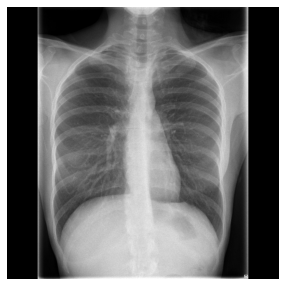

In [8]:

# Create the image associated to the filename stored previously
img = PILImage.create(path+fname)
img.show()
# Show the path of the annotations file associated to the image
print("Path of the annotations file:", img2txt_name(fname))
print("Image size:", img.size)

In [9]:
# Get annotations created with LabelImg of the bounding boxes corresponding to the lungs
# of an rx image

annotations = np.genfromtxt(img2txt_name(Path(fname))); annotations
# annotations has 2 elements, the first one refers to the bbox of the lung left 
# and the second one refers to the bbox of the lung right
# Each element of annotations refers to a bbox data and has the following format:
# idClass, center_x, center_y, width and height) 
#   center_x : X coordinate of the center of the bbox /Image_width
#   center_y: Y coordinate of the center of the bbox / Image_height
#   width: width of the bbox / Image_width
#   heigth: height of the bbox / Image_height


array([[0.      , 0.314885, 0.504771, 0.293893, 0.742366],
       [1.      , 0.655534, 0.504771, 0.280534, 0.727099]])

In [10]:
# Generate the bounding boxes of an image with Path "f"
#   "f" is a Path and not a filename because the DataBlock object used next gets the paths 
#   of all the images of the dataset & stores them in a list named "get_image_files"
#   For each image of the dataset, it's path is passed as parameter in get_bboxes to generate the target bounding boxes 
def get_bboxes(f):
    
    img = PILImage.create(path+f.name)

    # Get the annotations of the bounding boxes of the lungs of the rx image with Path "f"
    fullAnnot = np.genfromtxt(img2txt_name(f))

    bboxes = np.zeros((2,4))

    for i in range(len(fullAnnot)):
        cx = int(fullAnnot[i][1]*img.size[0]) 
        cy = int(fullAnnot[i][2]*img.size[1])
        
        w = int(fullAnnot[i][3]*img.size[0])
        h = int(fullAnnot[i][4]*img.size[1])
        
        bbox = np.zeros(4)
        bbox[0] = float(cx-w/2.0) # minx 
        bbox[1] = float(cy-h/2.0) # miny
        bbox[2] = float(cx+w/2.0) # maxX
        bbox[3] = float(cy+h/2.0) # maxY

        bboxes[i] = bbox

    return bboxes

# Get the labels of the bounding boxes of the image of Path "f"
#   0.0 -> lung left
#   1.0 -> lung right
# FUNCTION NOT USED FOR TRAINING, JUST ON THE TEST DONE BEFORE ON A SINGLE IMAGE
def get_labels(f):
    fullAnnot = np.genfromtxt(img2txt_name(Path(f)))
    labels = fullAnnot[:,0]
    return labels

In [11]:
# Create a LabeledBbox object from the bboxes parameter that contains a list of bboxes and their respective labels
def get_LabeledBBoxes (bboxes): return LabeledBBox(TensorBBox(bboxes[0]),bboxes[1]) 
# bboxes[0] is the list of bboxes; bboxes[1] is the list of labels associated to the bboxes

[TensorBBox([[ 87.5000,  70.0000, 240.5000, 458.0000],
        [270.0000,  74.0000, 416.0000, 454.0000]]), array([0., 1.])]


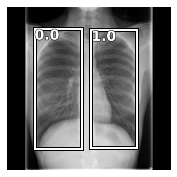

In [12]:
# Get the bboxes list and the associated bboxes list corresponding to the image with Path "fname"
labeledBboxes = [get_bboxes(Path(fname)), get_labels(Path(fname))]
tbboxes = get_LabeledBBoxes(labeledBboxes)
print(tbboxes)

# Show the image with the bounding boxes and their labels
ctx = img.show(figsize=(3,3), cmap='Greys')
tbboxes.show(ctx=ctx);

## Creating a dataset

In [13]:
# Cell
class NoLabelBBoxLabeler(Transform):
    """ Bounding box labeler with no label """
    def setups(self, x): noop
    def decode (self, x, **kwargs):
        self.bbox,self.lbls = None,None
        return self._call('decodes', x, **kwargs)

    def decodes(self, x:TensorBBox):
        self.bbox = x
        return self.bbox if self.lbls is None else LabeledBBox(self.bbox, self.lbls)

def custom_bb_pad(samples, pad_idx=0):
    "Function that collect `samples` of bboxes and adds padding with `pad_idx`."
    #samples = [(s[0], *clip_remove_empty(*s[1:])) for s in samples] # s[0] is a tuple of TensorImage & TensorBbox, TensorBbox size is (2,4)
    max_len = max([len(s[1]) for s in samples]) # equals to 4 (number of bbox coordinates)
    def _f(img,bbox):
        bbox = torch.cat([bbox,bbox.new_zeros(max_len-bbox.shape[0], 4)])        
        return img,bbox
    return [_f(*s) for s in samples]


CustomBboxBlock = TransformBlock(type_tfms=TensorBBox.create, 
                             item_tfms=[PointScaler, NoLabelBBoxLabeler], dls_kwargs = {'before_batch': custom_bb_pad})               

class BBoxReshape(DisplayedTransform):
    "Normalize/denorm batch of `TensorImage`"
    parameters,order = L(),100
    def __init__(self): 
        noop

    def setups(self, dl:DataLoader):
        noop

    def encodes(self, x:TensorBBox): return torch.reshape(x,(x.shape[0],8))
    def decodes(self, x:TensorBBox): return torch.reshape(x,(x.shape[0],2,4))

In [14]:
data = DataBlock(
    blocks=(ImageBlock, CustomBboxBlock), # ImageBlock means type of inputs are images; BBoxBlock & BBoxLblBlock = type of targets are BBoxes & their labels
    get_items=get_image_files,
    n_inp=1, # number of inputs; it's 1 because the only inputs are the rx images (ImageBlock)
    get_y= get_bboxes,
    splitter = GrandparentSplitter(), # split training/validation according to the parent folder name of the images
    batch_tfms= [*aug_transforms(do_flip=False, size=(120,160)), Normalize.from_stats(*imagenet_stats), BBoxReshape] 
)


In [15]:
path_dl = Path(path)
Path.BASE_PATH = path_dl
path_dl.ls().sorted()

(#602) [Path('71420984073006981695936500702397637989_aycior.png'),Path('71420984073006981695936500702397637989_aycior.txt'),Path('7149931905851290042143525080095735334_dr11hy.png'),Path('7149931905851290042143525080095735334_dr11hy.txt'),Path('71506354611877801878967117088709269901_k9fshf.png'),Path('71506354611877801878967117088709269901_k9fshf.txt'),Path('71510857005501688012913927744798484686_agvvsz.png'),Path('71510857005501688012913927744798484686_agvvsz.txt'),Path('71576696584101789388311784595829594064_dtor42.png'),Path('71576696584101789388311784595829594064_dtor42.txt')...]

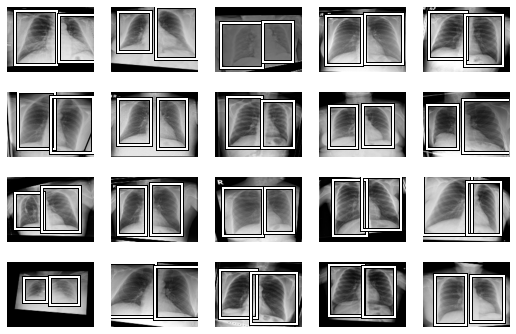

In [16]:
# Load the data and show a batch # NOTE: research to explain more properly what the 2 next lines do 

dls = data.dataloaders(path_dl, path=path_dl, bs = 64) # bs: how many samples per batch to load 
# If your GPU doesn't have enough memory and you can't run the whole notebook, 
# reduce the bs parameter value to, for example, 16 or 8
# and press the Restart button at the top of the notebook to empty the used memory

dls.show_batch(max_n=20, figsize=(9,6)) # NOTE: what do the values of figsize represent?
# NOTE: The batch shown contains validation and training images?

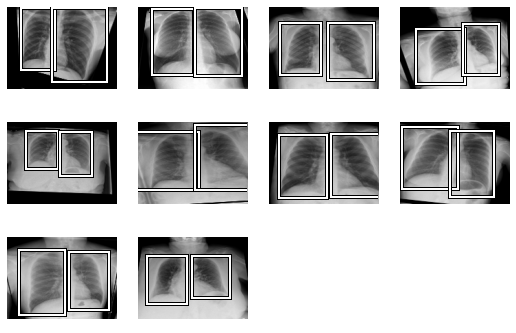

In [17]:
# Show a batch with less images than on the previous cell

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'show_batch')
# data.show_batch(10, figsize=(9,6)) 
# Instead of data.show_batch() it should be dls.show_batch() & the first argument must be max_n=10, not just 10 
dls.show_batch(max_n=10, figsize=(9,6)) 
# NOTE: figsize value is the same as on the previous cell but here the images are bigger, why? 
# I SUPPOSE figsize is the size of the window that contains all the images 

In [18]:
# Show the list of validation images

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'valid_ds')
# data.valid_ds.items
# Instead of data.valid_ds.items it should be dls.valid_ds.items 
dls.valid_ds.items

[Path('74340062289176841179216606105434866861_pb9ymm.png'),
 Path('9843354214953121119984032515630785434_fe4de5.png'),
 Path('78627091550672174628487115034022748573_nobnye.png'),
 Path('71830096813689790623247626285577839399_stk90p.png'),
 Path('73303572656184307011291199000449978423_sdb5dc.png'),
 Path('9006692146999611340617741952060883699_2nfys6.png'),
 Path('71865246281174473228459192797675573040_knhb95.png'),
 Path('73331384385988111703520361384738366272_qiw3p2.png'),
 Path('9361288573543559211612903453404315106_r9l3qn.png'),
 Path('9010531952147033496535640582177286331_l7g7sr.png'),
 Path('74414002541799532611807822790332393850_n8ottm.png'),
 Path('78202161155156629231567182345202755094_iiyvoy.png'),
 Path('75915889947259984366608486847488210419-2_ihg4dp.png'),
 Path('9412969183621042417296847332621432257_xcx5p5.png'),
 Path('73103728528181314905646325945773409506_9e2eli.png'),
 Path('73185203966325161214504949339889293386_k5qiz6.png'),
 Path('716159933634569047453607153431623255

In [19]:
# Get the data (PILImage, TensorBBox, TensorMultiCategory) of the first image of the validation dataset

# NOTE: why does batch variable encapsulates the type of data mentioned on the above line

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'valid_dl')
# batch = next(iter(data.valid_dl))
# Instead of data.valid_dl it should be dls.valid_ds
batch = next(iter(dls.valid_ds))

In [20]:
# Show the TensorBBox data of the batch variable created on the previous cell

# Next line from the original code is commented because it returns error ('PILImage' object is not subscriptable)
# batch[0][0][1]
# The output to the previous line shown on VICOROB's Github is: 
'''
tensor([[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        ...,
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
       device='cuda:0')
'''

# The closest output to the one of the original code is gotten by running the next line
batch[1]
# The output is: TensorBBox([[ 93.5000,  38.5000, 428.5000, 383.5000]])
# The function called is TensorBBox instead of tensor

# NOTE: Ask the professors why I can't get the same ouput as on the original code 
# What does the ouput of batch[0][0][1] from the original code represent?
# Why there is more than one inner list? On my ouput TensorBBox just has 1 list inside the outer list 

# And why the tensor has lists with at least 7 elements of the same value (-2.0357)?
# Shouldn't the lists have just 4 elements like on my output (the coordinates of the bbox)? 
# RESEARCH -> check if TensorBBox() is an upgrade of tensor(), do they do the same work?

TensorBBox([[ 62.0000,  70.5000, 250.0000, 397.5000],
        [276.0000,  68.0000, 454.0000, 420.0000]])

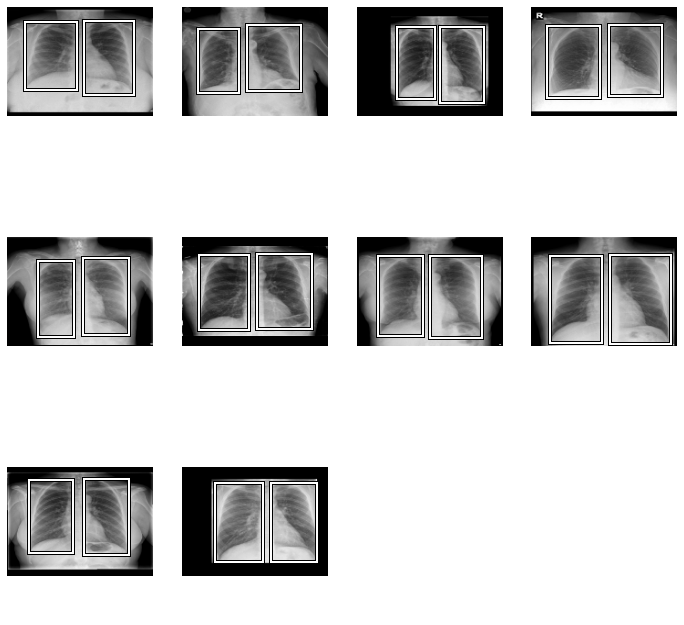

In [21]:
# Show a batch of validation images 

# Next line from the original code is commented because it returns error ('DataBlock' object has no attribute 'show_batch')
# data.show_batch(rows=10, ds_type=DatasetType.Valid, figsize=(12,12))
# I replaced the original line for the next one (it doesn't actually have the same behaviour because instead of rows=10 I use max_n=10,
# it's because the parameter rows is not longer part of the show_batch() method)

dls.valid.show_batch(max_n=10, figsize=(12,12))

## Train model
from https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb


In [22]:
def intersection(preds, targs):
    # preds and targs are of shape (validation dataset size, 8), pascal_voc format
    max_xy_left = torch.min(preds[:, 2:4], targs[:, 2:4]) # get the min max_xy between preds & targs because it's the max_xy of the inner bbox
    min_xy_left = torch.max(preds[:, :2], targs[:, :2]) # get the max min_xy between preds & targs because it's the min_xy of the inner bbox
    inter_left = torch.clamp((max_xy_left - min_xy_left), min=0) # store the dimensions of the inner bbox as 2D Tensor (x,y)
    # min=0 makes sure that none value of inter is < 0

    max_xy_right = torch.min(preds[:, 6:], targs[:, 6:]) 
    min_xy_right = torch.max(preds[:, 4:6], targs[:, 4:6]) 
    inter_right = torch.clamp((max_xy_right - min_xy_right), min=0) 
    
    inter = (inter_left[:, 0] * inter_left[:, 1]) + (inter_right[:, 0] * inter_right[:, 1]) # get the total area of the inner bboxes (left & right)
    
    return inter

def area(boxes): 
    area_left = ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1])) # area of a rectangle: (maxX - minX) * (maxY - minY)
    area_right = ((boxes[:, 6]-boxes[:, 4]) * (boxes[:, 7]-boxes[:, 5]))
    
    return (area_left + area_right)

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs): 
    inter = intersection(preds, targs)
    u = union(preds, targs)
    return inter / u

In [23]:
# Create the Lung Detector model from a pre-trained model  

class LungDetector(nn.Module):
    def __init__(self, arch=models.resnet18): # resnet18 has 18 lineal layers and it's the default arch if none arch is set as parameter
        super().__init__() 
        self.cnn = create_body(arch) # cut off the body of a typically pretrained arch
        self.head = create_head(num_features_model(self.cnn), 8)

    # NOTE: What does forward function mean?    
    def forward(self, im): # NOTE: what does im mean?
        x = self.cnn(im) # NOTE: why im is passed as parameter to cnn?
        x = self.head(x)
        # NOTE: Understand what the following line does?, what is x.sigmoid_()?
        return 2 * (x.sigmoid_() - 0.5) # (n_inp + bias) * n_out; bias = - 0.5, n_in = x.sigmoid_(), n_out = 2? (n_out I guess it should be 0 because now we don't have labels)

In [24]:
# Compare the output of the model (preds) with the ground truth (targs)
# If a high loss value is returned it mean the output is very different to the ground truth
# So, we want to get the minimum loss value possible

def loss_fn(preds, targs):
    return L1Loss()(preds, targs.squeeze()) # compute Mean Absolute Error # NOTE: check if squeeze is necessary? (squeeze turns i.e. 1x2x3 into 2x3)

In [25]:
# Create our own Learner object (we can also use Learners like cnn_learner() or unet_learner() ) 

# Check the documentation "https://fastai1.fast.ai/basic_train.html" to know about how a Learner works

# A Leaner is a trainer for model using data (dls) to minimize loss_func
# If path is provided, all the model files created will be saved in path/model_dir; if not, then they will be saved in data.path/model_dir.
learn = Learner(dls, LungDetector(arch=models.resnet50).cuda(), loss_func=loss_fn) # LungDetector.cuda() to work the model on GPU

#print(learn.summary()) # Show model layers data 

#learn.load('roi_detector_stage-1')
# If we have a saved model with the right accuracy, we can load it without having to train it again
# We can load a saved model by adding "learn.load(name of the model)" after "learn" has been initialized
# Then we have to comment all the following functions until the Data Augmentation cell
# because they had been previously executed on the loaded model

learn.metrics = [lambda preds, targs: IoU(preds, targs.squeeze()).mean()] # MODIFIED VERSION WITHOUT LABELS # NOTE: why it's a list?
# After every epoch, all metrics will be printed

# NOTE: check if targs.squeeze() on metrics is necessary? 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [26]:
# NOTE: Whats does split function do? Explain what this cell does.

# Split model layers into groups 
# NOTE: CHECK IF THE SPLIT HAS TO DO WITH USING A DISCRIMINATIVE LR
# Show the groups we will split next 
#print(learn.model.cnn[:6])
#print(learn.model.cnn[6:])
#print(learn.model.head)

learn._split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head]) # NOTE: What effect has a split?
#print(learn.summary()) # Show model layers data after split (same output as before split NOTE: why?)

### First traning (earlier layers freezed)



In [27]:
# Freeze all the layers of the model except the last one
# The next training will only update the weights of the last layer.
# Stop gradient calculations for earlier layers, and train only the last layer

learn.freeze_to(-1)

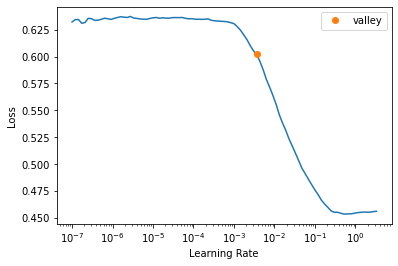

In [28]:
# Find the optimium learning rate with the learning rate finder

# Print the suggested learning rate and plot a learning rate / loss graphic
# where the displayed point indicates the suggested learning rate
lr_valley = learn.lr_find()

# lr_find DEFAULT SIGNATURE:
#   lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)
#   Explore learning rate from start_lr to end_lr over num_it iterations in learn. If stop_div, stops when loss diverges.

# NOTE
# Learning too slowly: If the learning rate is too small it will take 
# a really long time to train your model. 

# Learning too quickly: If the learning rate is too large, 
# the steps it takes will be so big it overshoots what is an optimal model. 
# Quite simply your accuracy will just bounce all over the place rather than 
# steadily improving.

In [29]:
# Fit our model with 100 epochs (epoch = complete pass trough the dataset)

# Fit a model following the 1cycle policy (fit_one_cycle)
#   "fit_one_cycle" defines a maximum learning rate. On each cycle/epoch the learning rate
#   gets through half of the iterations from the minimum learning rate to the defined maximum, 
#   and next half of the iterations go down to the minimum. On last couple of iterations the learning rate small decreasing.
# Check the documentation "https://fastai1.fast.ai/callbacks.one_cycle.html#What-is-1cycle?" to know more about the 1cycle policy 
%time learn.fit_one_cycle(200, lr_max=lr_valley, div=12, pct_start=0.2) # lr_max: a per cycle maximal learning rate
# NOTE: check what div and pct_start do?


# NOTE: what does pct_start mean?
# NOTE: What does "%time" do?
# NOTE: Why the 4th header of the output is invisible?


# An alternative to "fit_one_cycle" is "fit" 
#   Although, due to the fact that "fit" uses constant learning rates through all epochs, there would be needed more epochs to get 
#   the same results as on "fit_one_cycle"

epoch,train_loss,valid_loss,,time
0,0.626685,0.780556,0.000000,00:04
1,0.628138,0.922794,0.000000,00:04
2,0.621307,1.116166,0.000000,00:04
3,0.601975,1.298103,0.000000,00:04
4,0.575118,1.268963,0.000000,00:04
5,0.543627,1.173535,0.002555,00:04
6,0.514534,0.813803,0.141240,00:04
7,0.483380,0.443384,0.516789,00:04
8,0.455008,0.497274,0.415842,00:04
9,0.430445,0.449286,0.384982,00:04


CPU times: user 3min 5s, sys: 1min 52s, total: 4min 58s
Wall time: 15min 10s


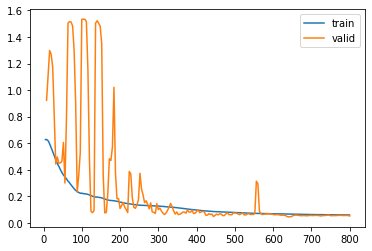

In [30]:
# Plot losses 

# If the model has been trained correctly train loss must be lower than validation loss.

learn.recorder.plot_loss() 
# X axis refers to the number of epochs 
# Y axis refers to the losses 

In [31]:
# Show some images data of the training dataset 
# First, we see the number of training images (#)
# Then, for each image, we see it's size and a TensorBBox object containing the bboxes coordinates
dls.train_ds

(#270) [(PILImage mode=RGB size=524x524, TensorBBox([[ 72.5000,  59.5000, 243.5000, 504.5000],
        [272.5000,  48.0000, 465.5000, 470.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 37.0000,  62.5000, 255.0000, 465.5000],
        [284.0000,  56.0000, 490.0000, 474.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 45.0000,  88.0000, 221.0000, 456.0000],
        [253.5000,  84.5000, 416.5000, 489.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 76.0000,  96.0000, 236.0000, 388.0000],
        [268.0000,  98.5000, 444.0000, 425.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[113.5000,  81.0000, 246.5000, 337.0000],
        [274.5000,  84.5000, 425.5000, 351.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 98.5000, 125.5000, 241.5000, 412.5000],
        [296.5000, 124.5000, 469.5000, 421.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 61.0000,  77.5000, 255.0000, 412.5000],
        [285.0000,  75.0000, 469.0000, 399.0000]])),(PILImage mode=RGB 

In [32]:
# Show some images data of the validation dataset 
# First, we see the number of validation images (#)
# Then, for each image, we see it's size and a TensorBBox object containing the bboxes coordinates
dls.valid_ds

(#30) [(PILImage mode=RGB size=524x524, TensorBBox([[ 62.0000,  70.5000, 250.0000, 397.5000],
        [276.0000,  68.0000, 454.0000, 420.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 56.0000, 103.5000, 204.0000, 410.5000],
        [233.0000,  86.0000, 427.0000, 400.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[143.0000,  94.5000, 279.0000, 439.5000],
        [300.5000,  93.5000, 455.5000, 460.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 56.5000,  89.5000, 245.5000, 434.5000],
        [276.5000,  85.5000, 469.5000, 424.5000]])),(PILImage mode=RGB size=524x524, TensorBBox([[107.5000, 112.5000, 240.5000, 479.5000],
        [270.0000, 100.0000, 438.0000, 470.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 59.5000,  83.0000, 240.5000, 445.0000],
        [269.0000,  77.0000, 465.0000, 439.0000]])),(PILImage mode=RGB size=524x524, TensorBBox([[ 74.5000,  87.5000, 237.5000, 474.5000],
        [264.0000,  88.5000, 450.0000, 483.5000]])),(PILImage mode=RGB s

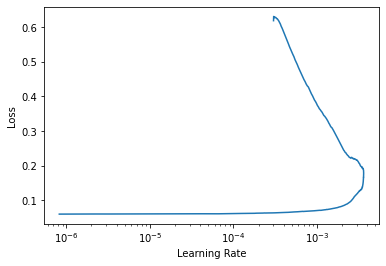

In [33]:
# Plot a Learning Rate - Loss graphic

learn.recorder.plot_lr_find() # it's not the same plot as learn.lr_find() because here the learning rate found is not shown 

### Second traning (layers unfreezed) 



In [34]:
# Unfreeze all the layers of the model, make all the layers trainable
# fit_one_cycle will update weights on all layers.
learn.unfreeze()

SuggestedLRs(valley=1.737800812406931e-05)

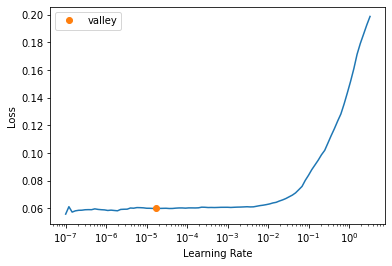

In [35]:
# Find a good learning rate with the learning rate finder after having unfreezed the model

learn.lr_find()

In [36]:
# Fit our model with 200 epochs by using discrminative learning rates
# Maintain a low learning rate for initial layers as they need lesser tuning 
# and gradually increase learning rate for later layers which need higher 
# tuning especially fully connected ones.

# Discriminative Learning Rates - Discriminative Layer Training
#lr_max = slice(lr_valley, lr_valley),  # maximal learning rate
# The first value passed to slice will be the learning rate in the earliest layer of the neural network, 
# and the second value will be the learning rate in the final layer. 
# The layers in between will have learning rates that are multiplicatively equidistant throughout that range
# and increments LR for later layers

%time learn.fit_one_cycle(300, lr_max=slice(1e-5,1e-3)) 

epoch,train_loss,valid_loss,,time
0,0.059730,0.052839,0.797323,00:04
1,0.058947,0.056093,0.788820,00:04
2,0.059865,0.056230,0.787683,00:04
3,0.060195,0.055152,0.791202,00:04
4,0.059995,0.051812,0.801397,00:04
5,0.059817,0.052277,0.800152,00:04
6,0.059671,0.052499,0.799611,00:04
7,0.059904,0.050959,0.803982,00:04
8,0.060171,0.050914,0.803548,00:04
9,0.060246,0.051214,0.801871,00:04


CPU times: user 4min 37s, sys: 2min 50s, total: 7min 28s
Wall time: 22min 39s


In [37]:
# Save the model 
learn.save('roi_detector_stage-1')
# The file gets stored at the models folder that is a new folder created inside the dataset folder 

# We can load this model after "learn" is initialized by calling to "learn.load(roi_detector_stage-1)"

Path('models/roi_detector_stage-1.pth')

In [38]:
# doing this metrics [] because pickle in export does not accept lambda functions...
learn.metrics = []


# Use export function to save the Learner in dataset path/fname, using pickle_protocol. 
# Note that serialization in Python saves the names of functions, not the code itself. 
# Therefore, any custom code you have for models, data transformation, loss function etc... 
# should be put in a module that you will import in your training environment before exporting, 
# and in your deployment environment before loading it.
learn.export('trained_roi_detetor_resnet_export.pkl') # NOTE: what type of program can open a pkl file?
# The file gets stored at the dataset folder 

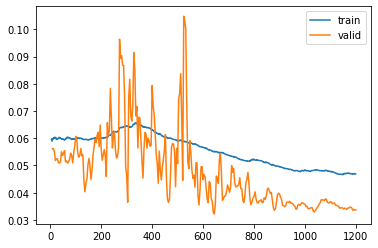

In [39]:
# Plot losses 

# If the model has been trained correctly train loss must be lower than validation loss.

learn.recorder.plot_loss()

## Inference

### Validation set

In [40]:
preds, targs = learn.get_preds() 
 
predicted_bboxes = ((preds + 1) / 2).numpy()
# (preds + 1) is used to make negative predictions turn into positive 
# NOTE: Why is ((preds + 1) divided by 2? are the predictions too big (I GET THAT IT'S A NORMALIZATION OF PREDICTIONS)
# numpy() converts to a ndarray Example size: (83,4)

targets = ((targs + 1) / 2).numpy()
# targs is a tuple of 2 elements, a TensorBBox (bboxes coordinates) and a TensorMultiCategory (bboxes labels)
# we have to normalize the bboxes coordinates, so we apply the normalization on targs[0]
# squeeze() makes targets size from (83,1,4) to (83,4)


def draw_bboxes(img, bboxes, target=None, color=(255, 0, 0), thickness=2):
# bboxes & target shape are (8,) the first 4 values refer to the coordinates of the left lung an ther last 4 ones refer 
# to the coordinates of the right lung

    sx,sy,ch = img.shape

    i = 0
    while(i < 8):
        bboxes[i] = bboxes[i]*sx # NOTE: why multiply by sy if bbox[0] refers to minx
        bboxes[i+1] = bboxes[i+1]*sy # NOTE: why multiply by sx if bbox[1] refers to minx
        bboxes[i+2] = bboxes[i+2]*sx
        bboxes[i+3] = bboxes[i+3]*sy
        x_min, y_min, x_max, y_max = map(int, bboxes[i:i+4])
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
        if target is not None:
            target[i] = target[i]*sx
            target[i+1] = target[i+1]*sy
            target[i+2] = target[i+2]*sx
            target[i+3] = target[i+3]*sy
            x_min, y_min, x_max, y_max = map(int, target[i:i+4])
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
        i = i+4
    return img

def cv_read(path): 
    path = str(path)
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

ims = np.stack([draw_bboxes(cv_read(dls.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(preds.shape[0])]) # store as many validation images as possible 

# Show some validation images with the predictions & targets of the bounding boxes (TARGETS ARE IN GREEN, PREDICTIONS ARE IN RED)
plt.figure(figsize=(40,40))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

### Test set (not working)

In [41]:
# Get test dataset
path = "Datasets/roi_detection_subset/test"
test_files = get_image_files(path)
# Create a test dataloader from test_items using validation transforms of dls
test_dl = learn.dls.test_dl(test_files) # Documentation: https://docs.fast.ai/data.core.html#DataLoaders.test_dl

preds = learn.get_preds(dl=test_dl) 
 
predicted_bboxes = ((preds + 1) / 2).numpy()
# (preds + 1) is used to make negative predictions turn into positive 
# NOTE: Why is ((preds + 1) divided by 2? are the predictions too big (I GET THAT IT'S A NORMALIZATION OF PREDICTIONS)
# numpy() converts to a ndarray Example size: (83,4)

targets = ((targs + 1) / 2).numpy()
# targs is a tuple of 2 elements, a TensorBBox (bboxes coordinates) and a TensorMultiCategory (bboxes labels)
# we have to normalize the bboxes coordinates, so we apply the normalization on targs[0]
# squeeze() makes targets size from (83,1,4) to (83,4)

ims = np.stack([draw_bboxes(cv_read(dls.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(preds.shape[0])]) # store as many validation images as possible 

# Show some validation images with the predictions & targets of the bounding boxes (TARGETS ARE IN GREEN, PREDICTIONS ARE IN RED)
plt.figure(figsize=(40,40))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

IndexError: ignored